In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"
# os.environ["CUDA_LAUNCH_BLOCKING"]="1"
import torch
import torch.nn.functional as F
import numpy as np
import json
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.transform
import argparse
from scipy.misc import imread, imresize
from PIL import Image
import pandas as pd

# from torch.nn.utils.rnn import pack_padded_sequence
from models import Encoder, DecoderWithAttention, CrossGPTLayer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

VERSION = 'GPT10'
WORD_NUM = '6'

from score import evalscores

import json
from pathlib import Path

I0604 20:55:47.977290 139704023820096 file_utils.py:41] PyTorch version 1.2.0 available.
/home/dchesakov/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dchesakov/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dchesakov/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

In [2]:
curr_path = Path(os.getcwd())

all_reports_df = pd.read_pickle(os.path.join(str(curr_path.parent), 'NLMCXR_data/all_reports_tags_df.pkl'))

NLMCXR_path = os.path.join(str(curr_path.parent), 'NLMCXR_data')
NLMCXR_path

'/home/dchesakov/skoltech_image_cap/NLMCXR_data'

In [3]:
all_reports_df.head(2)

,images,FINDINGS,IMPRESSION,tags_major,tags_automatic,report,full_report,processed_captions,processed_findings,preprocessed_full_report
0,CXR2357_IM-0921-1001,Cardiomediastinal silhouette and pulmonary vas...,No acute cardiopulmonary findings.,[normal],[],./reports/ecgen-radiology/2357.xml,No acute cardiopulmonary findings. Cardiomedia...,"[no acute cardiopulmonary findings, cardiomedi...",[cardiomediastinal silhouette and pulmonary va...,no acute cardiopulmonary findings . cardiomedi...
1,CXR2357_IM-0921-2001,Cardiomediastinal silhouette and pulmonary vas...,No acute cardiopulmonary findings.,[normal],[],./reports/ecgen-radiology/2357.xml,No acute cardiopulmonary findings. Cardiomedia...,"[no acute cardiopulmonary findings, cardiomedi...",[cardiomediastinal silhouette and pulmonary va...,no acute cardiopulmonary findings . cardiomedi...


In [4]:
from transformers import (WEIGHTS_NAME, AdamW, get_linear_schedule_with_warmup, get_constant_schedule, get_cosine_schedule_with_warmup,
                                  BertConfig, BertForMaskedLM, BertTokenizer,
                                  GPT2Config, GPT2LMHeadModel, GPT2Tokenizer,
                                  OpenAIGPTConfig, OpenAIGPTLMHeadModel, OpenAIGPTTokenizer,
                                  RobertaConfig, RobertaForMaskedLM, RobertaTokenizer,
                                  DistilBertConfig, DistilBertForMaskedLM, DistilBertTokenizer)

In [5]:
from transformers import GPT2Tokenizer, GPT2Model

import os
import numpy as np

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import torch

In [6]:
tokenizer = GPT2Tokenizer.from_pretrained(f'{NLMCXR_path}/output3')

I0604 20:55:55.360304 139704023820096 tokenization_utils.py:895] Model name '/home/dchesakov/skoltech_image_cap/NLMCXR_data/output3' not found in model shortcut name list (gpt2, gpt2-medium, gpt2-large, gpt2-xl, distilgpt2). Assuming '/home/dchesakov/skoltech_image_cap/NLMCXR_data/output3' is a path, a model identifier, or url to a directory containing tokenizer files.
I0604 20:55:55.361455 139704023820096 tokenization_utils.py:924] Didn't find file /home/dchesakov/skoltech_image_cap/NLMCXR_data/output3/added_tokens.json. We won't load it.
I0604 20:55:55.362645 139704023820096 tokenization_utils.py:977] loading file /home/dchesakov/skoltech_image_cap/NLMCXR_data/output3/vocab.json
I0604 20:55:55.363266 139704023820096 tokenization_utils.py:977] loading file /home/dchesakov/skoltech_image_cap/NLMCXR_data/output3/merges.txt
I0604 20:55:55.363845 139704023820096 tokenization_utils.py:977] loading file None
I0604 20:55:55.364538 139704023820096 tokenization_utils.py:977] loading file /home

In [7]:
gpt_model = GPT2LMHeadModel.from_pretrained(f'{NLMCXR_path}/output3', pad_token_id=tokenizer.eos_token_id)

I0604 20:55:56.032761 139704023820096 configuration_utils.py:284] loading configuration file /home/dchesakov/skoltech_image_cap/NLMCXR_data/output3/config.json
I0604 20:55:56.033793 139704023820096 configuration_utils.py:322] Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "pad_token_id": 50256,
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "vocab_size": 50257
}

I0604 20:55:56.034573 139704023820096 modeling_utils.py:610] loading weights file /home/dchesakov/skoltech_image_cap/NLMCXR_data/output3/pytorch_model.bin


In [8]:
def caption_image_beam_search_gpt(encoder, decoder, cross_m, image_path, word_map, beam_size=3):
    """
    Reads an image and captions it with beam search.

    :param encoder: encoder model
    :param decoder: decoder model
    :param image_path: path to image
    :param word_map: word map
    :param beam_size: number of sequences to consider at each decode-step
    :return: caption, weights for visualization
    """

    k = beam_size
    vocab_size = len(word_map)

    # Read image and process
    img = imread(image_path)
    if len(img.shape) == 2:
        img = img[:, :, np.newaxis]
        img = np.concatenate([img, img, img], axis=2)
    img = imresize(img, (256, 256))
    img = img.transpose(2, 0, 1)
    img = img / 255.
    img = torch.FloatTensor(img).to(device)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    image = transform(img)  # (3, 256, 256)

    # Encode
    image = image.unsqueeze(0)  # (1, 3, 256, 256)
    encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)

    # We'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

    # Tensor to store top k previous words at each step; now they're just <start>
    k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

    # Tensor to store top k sequences; now they're just <start>
    seqs = k_prev_words  # (k, 1)

    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

    # Tensor to store top k sequences' alphas; now they're just 1s
    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

    # Lists to store completed sequences, their alphas and scores
    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()

    # Start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)
    gpt_koeff = 0.

    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    while True:
        # print(step)
        
        embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

        awe, alpha = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

        alpha = alpha.view(-1, enc_image_size, enc_image_size)  # (s, enc_image_size, enc_image_size)

        gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
        awe = gate * awe

        h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

        scores = decoder.fc(h)  # (s, vocab_size)
        
        if True:
            
            gpt_pr = cross_m.idxs2gpt_predictions(seqs[:, :])
            gpt_new = cross_m.cross(torch.cat((scores.unsqueeze(1), gpt_pr[:,-1:,:]), dim=2))
            scores = cross_m.cross2(F.relu(gpt_new)).squeeze(1)
        
        # scores = cross_m(scores.unsqueeze(1), seqs.to(device), [seqs.shape[1]])
        
        # print(scores.shape)
        
        scores = F.log_softmax(scores, dim=1)
        
        
        scores = top_k_scores.expand_as(scores) + scores
        

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)
            

        # Convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words / vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)

        # Add new words to sequences, alphas
        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)],
                               dim=1)  # (s, step+1, enc_image_size, enc_image_size)

        # Which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                           next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
            # return (complete_seqs, complete_seqs_alpha, complete_seqs_scores)
            
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        seqs_alpha = seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            break
        step += 1
    try:
        i = complete_seqs_scores.index(max(complete_seqs_scores))
        seq = complete_seqs[i]
        alphas = complete_seqs_alpha[i]
        print(1)
        return seq, alphas
    except:
        return complete_seqs_scores, complete_seqs

In [9]:
def visualize_att_gpt(image_path, seq, alphas, rev_word_map, smooth=True, visualize=True):
    """
    Visualizes caption with weights at every word.

    Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb

    :param image_path: path to image that has been captioned
    :param seq: caption
    :param alphas: weights
    :param rev_word_map: reverse word mapping, i.e. ix2word
    :param smooth: smooth weights?
    """
    image = Image.open(image_path)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    words = [rev_word_map[ind] for ind in seq]
    
    # print(words)
    words = tokenizer.decode(tokenizer.encode(words[1:-1])).replace('.', ' . ').split()
    
    
    if visualize:
        for t in range(len(words)):
            if t > 50:
                break
            plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)

            plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
            plt.imshow(image)
            current_alpha = alphas[t, :]
            if smooth:
                alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
            else:
                alpha = skimage.transform.resize(current_alpha.numpy(), [14 * 24, 14 * 24])
            if t == 0:
                plt.imshow(alpha, alpha=0)
            else:
                plt.imshow(alpha, alpha=0.8)
            plt.set_cmap(cm.Greys_r)
            plt.axis('off')
        plt.show()
    
    return words

In [11]:
v = VERSION
n = WORD_NUM

In [12]:
def get_print_gpt(img_name, visualize=True, print_res=True):
    parser = argparse.ArgumentParser(description='Show, Attend, and Tell - Tutorial - Generate Caption')
    parser.add_argument('--img', '-i', default=f'{NLMCXR_path}/images/{img_name}.png', help='path to image')
    parser.add_argument('--model', '-m', default=f'BEST_checkpoint_NLMCXR_v{v}_1_cap_per_img_{n}_min_word_freq.pth.tar', help='path to model')
    parser.add_argument('--word_map', '-wm', default=f'{NLMCXR_path}/WORDMAP_NLMCXR_v{v}_1_cap_per_img_{n}_min_word_freq.json',  help='path to word map JSON')
    parser.add_argument('--beam_size', '-b', default=5, type=int, help='beam size for beam search')
    parser.add_argument('--dont_smooth', dest='smooth', action='store_false', help='do not smooth alpha overlay')
    
    args = args = parser.parse_args('')
    
    checkpoint = torch.load(args.model)
    
    decoder = checkpoint['decoder']
    decoder = decoder.to(device)
    decoder.eval()
    
    encoder = checkpoint['encoder']
    encoder = encoder.to(device)
    encoder.eval()
    
    cross_m = checkpoint['cross_m']
    cross_m = cross_m.to(device)
    cross_m.eval()

    # Load word map (word2ix)
    with open(args.word_map, 'r') as j:
        word_map = json.load(j)
    rev_word_map = {v: k for k, v in word_map.items()}  # ix2word

    # Encode, decode with attention and beam search
    seq, alphas = caption_image_beam_search_gpt(encoder, decoder, cross_m, args.img, word_map, args.beam_size)
    alphas = torch.FloatTensor(alphas)
    
    if print_res:
        print(asd[ asd['images'] == f'{img_name}']['processed_findings'].iloc[0])

    # Visualize caption and attention of best sequence
    words = visualize_att_gpt(args.img, seq, alphas, rev_word_map, args.smooth, visualize=visualize)
    
    return words

In [13]:
img_path = f'{NLMCXR_path}/images/CXR2194_IM-0804-2001.png'

In [14]:
# seq, alphas = caption_image_beam_search_gpt(encoder, decoder, cross_m, img_path, word_map, beam_size=3)

In [15]:
asd = pd.read_pickle(f'{NLMCXR_path}/all_reports_df.pkl')
asd.head()

,Unnamed: 0,images,FINDINGS,IMPRESSION,tags,full_report,processed_captions,tag_list,processed_findings
0,0,CXR2357_IM-0921-1001,Cardiomediastinal silhouette and pulmonary vas...,No acute cardiopulmonary findings.,normal,No acute cardiopulmonary findings. Cardiomedia...,"['no acute cardiopulmonary findings', 'cardiom...",['normal'],[cardiomediastinal silhouette and pulmonary va...
1,1,CXR2357_IM-0921-2001,Cardiomediastinal silhouette and pulmonary vas...,No acute cardiopulmonary findings.,normal,No acute cardiopulmonary findings. Cardiomedia...,"['no acute cardiopulmonary findings', 'cardiom...",['normal'],[cardiomediastinal silhouette and pulmonary va...
2,0,CXR3620_IM-1791-1001-0001,The cardiac silhouette is near upper limits of...,1. Minimal left basilar atelectasis or scar. 2...,scar,1. Minimal left basilar atelectasis or scar. 2...,"['minimal left basilar atelectasis or scar', '...",['scar'],[the cardiac silhouette is near upper limits o...
3,1,CXR3620_IM-1791-1001-0002,The cardiac silhouette is near upper limits of...,1. Minimal left basilar atelectasis or scar. 2...,scar,1. Minimal left basilar atelectasis or scar. 2...,"['minimal left basilar atelectasis or scar', '...",['scar'],[the cardiac silhouette is near upper limits o...
4,0,CXR3911_IM-1987-1001,NaN,Heart size is normal and lungs are clear. No p...,normal,Heart size is normal and lungs are clear. No p...,"['heart size is normal and lungs are clear', '...",['normal'],NaN


/home/dchesakov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/dchesakov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


1
['the lungs are clear', 'heart size is normal', 'no pneumothorax', 'calcified granuloma within the right lung base']


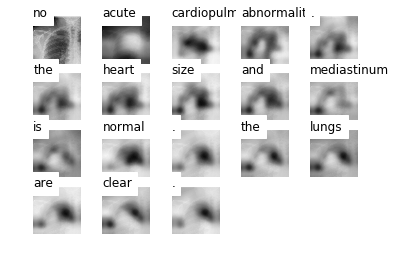

['no',
 'acute',
 'cardiopulmonary',
 'abnormality',
 '.',
 'the',
 'heart',
 'size',
 'and',
 'mediastinum',
 'is',
 'normal',
 '.',
 'the',
 'lungs',
 'are',
 'clear',
 '.']

In [16]:
get_print_gpt('CXR2992_IM-1379-2002')

In [17]:
all_reports_df = pd.read_pickle(f'{NLMCXR_path}/all_reports_tags_df.pkl')
    # all_reports_df = all_reports_df[ all_reports_df['processed_findings'].notnull() ]
# train_df, val_df, test_df = train_validate_test_split(all_reports_df, .9, .05, seed=42)
train_df = all_reports_df[:-600]
val_df = all_reports_df[-600:-300]
# test_df = all_reports_df[-600:]
test_df = all_reports_df[-300:]

test_predicts = []
test_images = test_df.images.values

In [18]:
all_reports_df[-600:]

,images,FINDINGS,IMPRESSION,tags_major,tags_automatic,report,full_report,processed_captions,processed_findings,preprocessed_full_report
1,CXR1436_IM-0280-1002,The cardiac and mediastinal contours are withi...,1. Haziness in the right lung apex and questio...,"[calcinosis, aorta, lung, hyperdistention, dia...","[degenerative change, nodule, overlapping stru...",./reports/ecgen-radiology/1436.xml,1. Haziness in the right lung apex and questio...,[haziness in the right lung apex and questiona...,[the cardiac and mediastinal contours are with...,haziness in the right lung apex and questionab...
0,CXR2784_IM-1220-1001,The heart is normal in size and contour. There...,No acute cardiopulmonary abnormalities.,[normal],[],./reports/ecgen-radiology/2784.xml,No acute cardiopulmonary abnormalities. The he...,"[no acute cardiopulmonary abnormalities, the h...","[the heart is normal in size and contour, ther...",no acute cardiopulmonary abnormalities . the h...
1,CXR2784_IM-1220-2001,The heart is normal in size and contour. There...,No acute cardiopulmonary abnormalities.,[normal],[],./reports/ecgen-radiology/2784.xml,No acute cardiopulmonary abnormalities. The he...,"[no acute cardiopulmonary abnormalities, the h...","[the heart is normal in size and contour, ther...",no acute cardiopulmonary abnormalities . the h...
0,CXR2194_IM-0804-10001,None,Stable enlarged cardiomediastinal silhouette. ...,"[cardiac shadow, enlarged, aorta, tortuous, lu...","[atelectases, opacity, pleural effusions, pleu...",./reports/ecgen-radiology/2194.xml,Stable enlarged cardiomediastinal silhouette. ...,"[stable enlarged cardiomediastinal silhouette,...",NaN,stable enlarged cardiomediastinal silhouette ....
1,CXR2194_IM-0804-2001,None,Stable enlarged cardiomediastinal silhouette. ...,"[cardiac shadow, enlarged, aorta, tortuous, lu...","[atelectases, opacity, pleural effusions, pleu...",./reports/ecgen-radiology/2194.xml,Stable enlarged cardiomediastinal silhouette. ...,"[stable enlarged cardiomediastinal silhouette,...",NaN,stable enlarged cardiomediastinal silhouette ....
2,CXR2194_IM-0804-9001,None,Stable enlarged cardiomediastinal silhouette. ...,"[cardiac shadow, enlarged, aorta, tortuous, lu...","[atelectases, opacity, pleural effusions, pleu...",./reports/ecgen-radiology/2194.xml,Stable enlarged cardiomediastinal silhouette. ...,"[stable enlarged cardiomediastinal silhouette,...",NaN,stable enlarged cardiomediastinal silhouette ....
0,CXR1683_IM-0449-1001,The XXXX examination consists of frontal and l...,No evidence of acute cardiopulmonary process. ...,"[lung, hypoinflation, lung, hilum, lymph nodes...","[deformity, hilar adenopathy, sarcoidoses, lym...",./reports/ecgen-radiology/1683.xml,No evidence of acute cardiopulmonary process. ...,"[no evidence of acute cardiopulmonary process,...",[the xxxx examination consists of frontal and ...,no evidence of acute cardiopulmonary process ....
1,CXR1683_IM-0449-2001,The XXXX examination consists of frontal and l...,No evidence of acute cardiopulmonary process. ...,"[lung, hypoinflation, lung, hilum, lymph nodes...","[deformity, hilar adenopathy, sarcoidoses, lym...",./reports/ecgen-radiology/1683.xml,No evidence of acute cardiopulmonary process. ...,"[no evidence of acute cardiopulmonary process,...",[the xxxx examination consists of frontal and ...,no evidence of acute cardiopulmonary process ....
0,CXR2273_IM-0861-1001,Lungs are clear. No pleural effusions or pneum...,Clear lungs.,[normal],[],./reports/ecgen-radiology/2273.xml,Clear lungs. Lungs are clear. No pleural effus...,"[clear lungs, lungs are clear, no pleural effu...","[lungs are clear, no pleural effusions or pneu...",clear lungs . lungs are clear . no pleural eff...
1,CXR2273_IM-0861-1002,Lungs are clear. No pleural effusions or pneum...,Clear lungs.,[normal],[],./reports/ecgen-radiology/2273.xml,Clear lungs. Lungs are clear. No pleural effus...,"[clear lungs, lungs are clear, no pleural effu...","[lungs are clear, no pleural effusions or pneu...",cl

In [19]:
all_reports_df2 = pd.read_pickle(f'{NLMCXR_path}/all_reports_tags_df.pkl')

In [20]:
test_images

array(['CXR1484_IM-0313-2001', 'CXR2767_IM-1212-1001',
       'CXR2767_IM-1212-2001', 'CXR10_IM-0002-1001', 'CXR10_IM-0002-2001',
       'CXR3167_IM-1491-1001', 'CXR3167_IM-1491-2001',
       'CXR1533_IM-0344-1001', 'CXR1533_IM-0344-1002',
       'CXR2988_IM-1375-1001', 'CXR2988_IM-1375-2001',
       'CXR3623_IM-1793-1001', 'CXR3623_IM-1793-1002',
       'CXR1894_IM-0581-1001', 'CXR1894_IM-0581-2001',
       'CXR3254_IM-1543-1001', 'CXR3254_IM-1543-2001',
       'CXR2540_IM-1052-1001', 'CXR2540_IM-1052-2001',
       'CXR1205_IM-0138-1001', 'CXR1205_IM-0138-1002',
       'CXR3633_IM-1800-1001', 'CXR3633_IM-1800-1002',
       'CXR1018_IM-0014-5001', 'CXR1018_IM-0014-6001',
       'CXR1902_IM-0586-1001', 'CXR1902_IM-0586-2001',
       'CXR1231_IM-0155-1001', 'CXR1231_IM-0155-2001',
       'CXR1826_IM-0535-0001', 'CXR1826_IM-0535-1001',
       'CXR903_IM-2409-1001', 'CXR903_IM-2409-1002',
       'CXR2369_IM-0929-2001', 'CXR98_IM-2467-1001', 'CXR98_IM-2467-4004',
       'CXR425_IM-2068-1001

In [22]:
from tqdm import tqdm, tqdm_notebook

In [23]:
test_df = all_reports_df[-300:]

In [23]:
test_predicts = []

err_idx = []
err_idx_before = []
ok_idx = []
ok_idx_before = []
ok_names = []
err_names = []

for i, img_name in tqdm_notebook(enumerate(test_images)):
    try:
        words = get_print_gpt(img_name, visualize=False, print_res=False)
        ok_idx.append(i)
        ok_names.append(img_name)
        print(f'ok idx {i}')
        test_predicts.append(words)
    except:
        err_idx.append(i)
        err_names.append(img_name)
        print(f'err idx {i}')
    if i == 10:
        break

/home/dchesakov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/dchesakov/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


1
ok idx 0
1
ok idx 1
1
ok idx 2
1
ok idx 3
1
ok idx 4
1
ok idx 5
1
ok idx 6
1
ok idx 7
err idx 8
1
ok idx 9
1
ok idx 10


In [24]:
max_len = 100

test_image_captions = [[sents.split()][:max_len] for sents in test_df['preprocessed_full_report'].values[ok_idx]]

In [25]:
len(test_image_captions)

10

In [26]:
evalscores(test_predicts, test_image_captions)

Bleu_1: 0.406
Bleu_2: 0.283
Bleu_3: 0.203
Bleu_4: 0.140
ROUGE_L: 0.365
CIDEr: 0.520


In [49]:
N = 6

In [50]:
' '.join(test_predicts[N])

'no acute cardiopulmonary abnormalities . the heart size and mediastinal silhouette are within normal limits for contour . the lungs are clear . no pneumothorax or pleural effusions . the xxxx are intact .'

In [51]:
' '.join(test_image_captions[N][0])

'no acute cardiopulmonary abnormality . lungs are clear bilaterally . cardiac and mediastinal silhouettes are normal . pulmonary vasculature is normal . no pneumothorax or pleural effusion . no acute bony abnormality .'

In [52]:
name = ok_names[N]

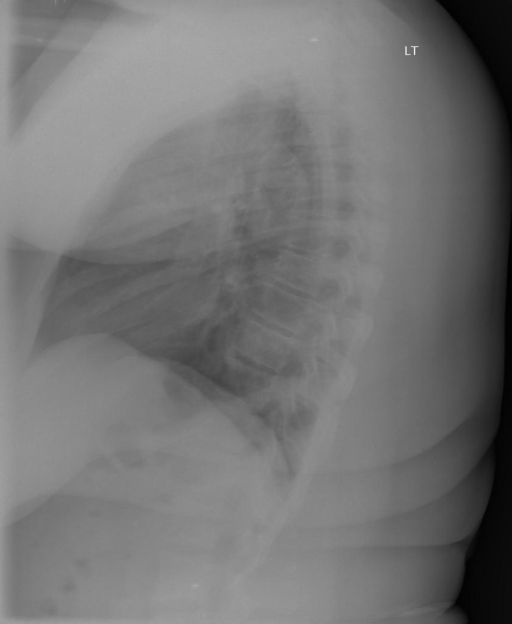

In [53]:
Image.open(f'/home/dchesakov/NLMCXR_data/images/{name}.png')

In [403]:
evalscores(test_predicts[:5], test_image_captions[:5])

Bleu_1: 0.460
Bleu_2: 0.334
Bleu_3: 0.250
Bleu_4: 0.181
ROUGE_L: 0.396
CIDEr: 0.800


In [312]:
evalscores(test_predicts, test_image_captions)

Bleu_1: 0.234
Bleu_2: 0.143
Bleu_3: 0.097
Bleu_4: 0.069
ROUGE_L: 0.269
CIDEr: 0.255
